In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

### MNIST Dataset

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [3]:
default_batch_size = 32
loader_args = {'batch_size' : default_batch_size, 'shuffle' : True}
if use_cuda:
    loader_args.update({'pin_memory' : True, 'num_workers' : 1})

In [4]:
testset  = datasets.MNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())
test_loader = utils.data.DataLoader(testset, **loader_args)

In [5]:
label_size = 10

### MNIST CNN Model

In [6]:
class MNISTClassifier(nn.Module):
    def __init__(self, isize, osize):
        super(MNISTClassifier, self).__init__()
        fc1_isize = int((((isize - 2 - 2) / 2) ** 2) * 32)
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(fc1_isize, 128)
        self.fc2 = nn.Linear(128, osize)

    def forward(self, x):
        return self.f_fc2(x)

    # extended to access intermediate layer outputs
    def f_conv1(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        return x
    def f_conv2(self, x):
        x = self.f_conv1(x)
        x = self.conv2(x)
        x = F.relu(x)
        return x
    def f_pool1(self, x):
        x = self.f_conv2(x)
        x = self.pool(x)
        return x
    def f_fc1(self, x):
        x = self.f_pool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    def f_fc2(self, x):
        x = self.f_fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [7]:
model_file = '../models/mnist_classifier.pt'
model = torch.load(model_file)
model = model.to(device)

### Report Model Performance with Confusion Matrix

In [8]:
def predict(model, device, loader):
    model.eval()
    inputs = np.empty((0,1,28,28), dtype=float)
    predictions = np.empty(0)
    targets = np.empty(0)
    with torch.no_grad():
        for data, target in loader:
            inputs = np.concatenate((inputs, data), axis=0)
            data = data.to(device)
            output = model(data)
            prediction = output.argmax(dim=1)
            prediction = prediction.cpu()
            targets = np.concatenate((targets, target), axis=0)
            predictions = np.concatenate((predictions, prediction), axis=0)
    return (predictions, targets, inputs)

In [9]:
def predictions_to_matrix(predictions, targets, n_classes):
    mtx = [[0 for i in range(n_classes)] for i in range(n_classes)]
    for i in range(len(predictions)):
        mtx[int(predictions[i])][int(targets[i])] += 1
    return mtx

In [10]:
predictions, targets, inputs = predict(model, device, test_loader)

In [11]:
confusion_matrix = predictions_to_matrix(predictions, targets, label_size)

<AxesSubplot:>

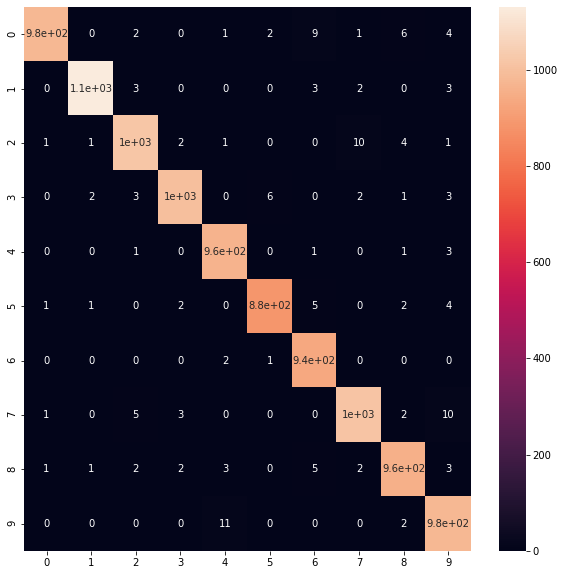

In [12]:
df = pd.DataFrame(confusion_matrix, index=[i for i in range(label_size)], columns=[i for i in range(label_size)])
plt.figure(figsize=(10, 10))
sn.heatmap(df, annot=True)

### Sample of Incorrect Predictions

In [50]:
tensor2image = transforms.ToPILImage()

In [14]:
def incorrect(predictions, targets, inputs):
    ret = []
    for i, (pred, targ) in enumerate(zip(predictions, targets)):
        if pred != targ:
            ret.append((i, targ, pred, inputs[i]))
    return ret

In [15]:
incorrects = incorrect(predictions, targets, inputs)

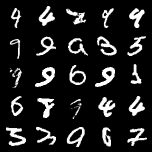

In [16]:
sample_idxes = [random.randint(0, len(incorrects) - 1) for _ in range(25)]
incorrect_images = np.empty((0,1,28,28))
for i in sample_idxes:
    incorrect_images = np.concatenate((incorrect_images, np.expand_dims(incorrects[i][3], axis=0)), axis=0)
incorrect_images = torch.from_numpy(incorrect_images)
incorrect_image_grid = torchvision.utils.make_grid(incorrect_images, nrow=5)
tensor2image(incorrect_image_grid)

In [26]:
sample_idx = random.randint(0, len(incorrects) - 1)
incorrect_image = torch.from_numpy(incorrects[sample_idx][3]).type(torch.FloatTensor)

In [27]:
tensor2image(incorrect_image)

In [28]:
print("Correct Label: {} Prediction Label: {}".format(incorrects[sample_idx][1], incorrects[sample_idx][2]))

Correct Label: 1.0 Prediction Label: 3.0


### Visualizing Model Internals with sample image

In [29]:
incorrect_input = incorrect_image
incorrect_input = incorrect_input.unsqueeze_(0)
incorrect_input = incorrect_input.to(device)

In [30]:
conv1_output = model.f_conv1(incorrect_input)

In [31]:
conv1_output.size()

torch.Size([1, 64, 26, 26])

In [63]:
def create_output_grid(output, rowsize, layer_size, imgsize):
    output = output.squeeze().cpu().detach()
    output_images = torch.reshape(output, (layer_size, 1, imgsize, imgsize))
    grid = torchvision.utils.make_grid(output_images, nrow=rowsize)
    return grid

### Visualizing First Convolutional Layer output

In [64]:
conv1_output_image_grid = create_output_grid(conv1_output, 8, 64, 26)

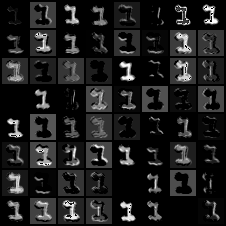

In [65]:
tensor2image(conv1_output_image_grid)

In [ ]:
### Visualizing Second Convolutional Layer output

In [61]:
conv2_output = model.f_conv2(incorrect_input)

In [62]:
conv2_output.size()

torch.Size([1, 32, 24, 24])

In [66]:
conv2_output_image_grid = create_output_grid(conv2_output, 6, 32, 24)

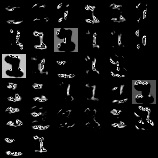

In [67]:
tensor2image(conv2_output_image_grid)

### Visualizing Max Pooling Layer

In [68]:
pool1_output = model.f_pool1(incorrect_input)

In [69]:
pool1_output.size()

torch.Size([1, 32, 12, 12])

In [70]:
pool1_output_image_grid = create_output_grid(pool1_output, 6, 32, 12)

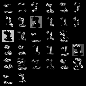

In [71]:
tensor2image(pool1_output_image_grid)